In [1]:
import findspark

In [2]:
findspark.init("/opt/manual/spark")

In [3]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd

In [4]:
spark = SparkSession.builder \
.appName("Churn Scoring with GBT") \
.master("yarn") \
.getOrCreate()

In [5]:
spark.version

'3.0.0'

In [6]:
! hdfs dfs -ls /user/train/datasets/churn-telecom

Found 3 items
-rw-r--r--   1 train supergroup    5213392 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2cellholdout.csv
-rw-r--r--   1 train supergroup   13416201 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain.csv
drwxr-xr-x   - train supergroup          0 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain_clean_parquet


## Read train data

In [7]:
df1 = spark.read.format("parquet") \
.load("hdfs://localhost:9000/user/train/datasets/churn-telecom/cell2celltrain_clean_parquet")

## Explore train data

In [8]:
# Since there are many columns we'd better explore part by part 
df1.select(df1.columns[40:]) \
.limit(46).toPandas()

,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,No,No,Yes,Yes,1.0,0.0,No,No,0.0,4.0,No,0.0,30.0,Yes,1-Highest,Suburban,Professional,No
1,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,0.0,30.0,No,4-Medium,Suburban,Professional,Yes
2,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,130.0,No,3-Good,Town,Crafts,Yes
3,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,10.0,No,4-Medium,Other,Other,No
4,No,No,Yes,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,10.0,No,1-Highest,Other,Professional,Yes
5,No,Yes,No,Yes,0.0,0.0,Yes,No,0.0,1.0,No,1.0,30.0,No,3-Good,Other,Other,Yes
6,No,Yes,No,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,30.0,No,1-Highest,Other,Self,Yes
7,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,30.0,No,1-Highest,Other,Professional,No
8,No,No,No,Yes,0.0,0.0,Yes,No,0.0,9.0,No,0.0,80.0,No,1-Highest,Other,Other,Yes
9,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,1.0,30.0,No,3-Good,Other,Professional,No


In [10]:
# Schema change analysis

# MonthlyRevenue, MonthlyMinutes, TotalRecurringCharge, OverageMinutes, PercChangeMinutes, PercChangeRevenues
# Handsets, HandsetModels, CurrentEquipmentDays, AgeHH1, AgeHH2  to integer

# DirectorAssistedCalls, HandsetPrice to float

In [9]:
len(df1.columns)

58

In [11]:
df1.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: double (nullable = true)
 |-- MonthlyMinutes: double (nullable = true)
 |-- TotalRecurringCharge: double (nullable = true)
 |-- DirectorAssistedCalls: double (nullable = true)
 |-- OverageMinutes: double (nullable = true)
 |-- RoamingCalls: double (nullable = true)
 |-- PercChangeMinutes: double (nullable = true)
 |-- PercChangeRevenues: double (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

In [10]:
# Null check
for(col_name, col_type) in zip(df1.columns, df1.dtypes):
    null_count = df1.filter( (F.col(col_name).isNull()) | (F.col(col_name) == "")).count()
    if(  null_count > 0 ):
        print("{} {} type has {} null values".format(col_name, col_type[1], null_count))

# Distribution of Output/Target variable

In [11]:
df1.select("Churn").groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No|36335|
|  Yes|14711|
+-----+-----+



<AxesSubplot:>

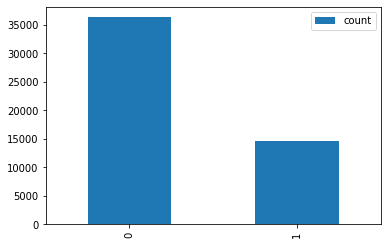

In [12]:
df1.select("Churn").groupBy("Churn").count().toPandas().plot(kind='bar')

# Data Preperation for the Model

In [14]:
categoric_cols = []
numeric_cols = []
discarted_cols = []
label_col = []

In [15]:
# column seperation
for col_name in df1.dtypes:
    if (col_name[0] not in []):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [16]:
for col_name in categoric_cols:
    df1.groupBy(col_name).agg(F.count("*").alias("TotalCount")).orderBy(F.desc("TotalCount")).show()

+-----+----------+
|Churn|TotalCount|
+-----+----------+
|   No|     36335|
|  Yes|     14711|
+-----+----------+

+-----------+----------+
|ServiceArea|TotalCount|
+-----------+----------+
|  NYCBRO917|      1684|
|  HOUHOU281|      1510|
|  DALDAL214|      1498|
|  NYCMAN917|      1182|
|  APCFCH703|       783|
|  DALFTW817|       782|
|  SANSAN210|       724|
|  APCSIL301|       670|
|  SANAUS512|       612|
|  SFROAK510|       605|
|  SFRSFR415|       565|
|  NYCQUE917|       533|
|  ATLANE678|       524|
|  PHXPHX602|       512|
|  SFRSCL408|       508|
|  ATLATL678|       507|
|  STLSTL314|       497|
|  OHICOL614|       486|
|  MINMIN612|       481|
|  NEVLVS702|       479|
+-----------+----------+
only showing top 20 rows

+------------+----------+
|ChildrenInHH|TotalCount|
+------------+----------+
|          No|     38678|
|         Yes|     12368|
+------------+----------+

+------------------+----------+
|HandsetRefurbished|TotalCount|
+------------------+----------+
|     

In [17]:
# column seperation after analysis
categoric_cols = []
numeric_cols = []
# Why we discard these? Because they have high cardinality. In other words they have too many distinct categories
# Adding them to model will not do good if not too bad.
discarted_cols = ['CustomerID', 'ServiceArea']
label_col = ['Churn']

In [18]:
for col_name in df1.dtypes:
    if (col_name[0] not in discarted_cols+label_col):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [19]:
print(categoric_cols)
print(len(categoric_cols))

['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']
20


In [20]:
print(numeric_cols)
print(len(numeric_cols))

['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'HandsetPrice']
35


In [21]:
print(discarted_cols+label_col)
print(len(discarted_cols+label_col))

['CustomerID', 'ServiceArea', 'Churn']
3


## verification of columns

In [22]:
if len(df1.columns) == (len(categoric_cols)+len(numeric_cols)+len(discarted_cols+label_col)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


## Select columns for onehotencoder

In [23]:
# Here we count the distinct categories in categoric columns. If there is more than two,
# we will add those to to_be_onehotencoded_cols list If there is just 2 we don't need to use onehotencoder
# So if distinct category gt 2 we have to add it to_be_onehotencoded_cols list
to_be_onehotencoded_cols = []

for col_name in categoric_cols:
    count = df1.select(col_name).distinct().count()
    if count > 2:
        to_be_onehotencoded_cols.append(col_name)
    print("{} has {} distinct category.".format(col_name, count))
    

ChildrenInHH has 2 distinct category.
HandsetRefurbished has 2 distinct category.
HandsetWebCapable has 2 distinct category.
TruckOwner has 2 distinct category.
RVOwner has 2 distinct category.
Homeownership has 2 distinct category.
BuysViaMailOrder has 2 distinct category.
RespondsToMailOffers has 2 distinct category.
OptOutMailings has 2 distinct category.
NonUSTravel has 2 distinct category.
OwnsComputer has 2 distinct category.
HasCreditCard has 2 distinct category.
NewCellphoneUser has 2 distinct category.
NotNewCellphoneUser has 2 distinct category.
OwnsMotorcycle has 2 distinct category.
MadeCallToRetentionTeam has 2 distinct category.
CreditRating has 7 distinct category.
PrizmCode has 4 distinct category.
Occupation has 8 distinct category.
MaritalStatus has 3 distinct category.


In [29]:
print(to_be_onehotencoded_cols)

['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']


# StringIndexer

In [25]:
from pyspark.ml.feature import StringIndexer

In [26]:
# Will hold stringIndexer objects and column names
my_dict = {}

# Will collect StringIndexer ojects
string_indexer_objs = []

# Will collect StringIndexer output colnames
string_indexer_output_names = []

# Will collect OneHotEncoder output colnames
ohe_col_input_names = []
ohe_col_output_names = []

for col_name in categoric_cols:
    my_dict[col_name+"_indexobj"] = StringIndexer() \
    .setHandleInvalid('skip') \
    .setInputCol(col_name) \
    .setOutputCol(col_name+"_indexed")
    
    string_indexer_objs.append(my_dict.get(col_name+"_indexobj"))
    string_indexer_output_names.append(col_name+"_indexed")
    if col_name in to_be_onehotencoded_cols:
        ohe_col_input_names.append(col_name+"_indexed")
        ohe_col_output_names.append(col_name+"_ohe")

In [27]:
print(string_indexer_objs)
print(len(string_indexer_objs))

[StringIndexer_1809c14c5d98, StringIndexer_0b415dc54b8e, StringIndexer_37faf319ddab, StringIndexer_90ad61d19d85, StringIndexer_905b7e55ae58, StringIndexer_ba1e8e2ac022, StringIndexer_dbe45be44709, StringIndexer_3bc378c9cb87, StringIndexer_bd43f60c2928, StringIndexer_4d08b22e6c3a, StringIndexer_706663ba1b3d, StringIndexer_048491c7beaf, StringIndexer_b0c691644e28, StringIndexer_7def6f78b174, StringIndexer_24f29637c24a, StringIndexer_2206ec646105, StringIndexer_7c2e20a2738c, StringIndexer_6345e30a163c, StringIndexer_126b8ee9911d, StringIndexer_92924f7d56f1]
20


In [28]:
print(string_indexer_output_names)
print(len(string_indexer_output_names))

['ChildrenInHH_indexed', 'HandsetRefurbished_indexed', 'HandsetWebCapable_indexed', 'TruckOwner_indexed', 'RVOwner_indexed', 'Homeownership_indexed', 'BuysViaMailOrder_indexed', 'RespondsToMailOffers_indexed', 'OptOutMailings_indexed', 'NonUSTravel_indexed', 'OwnsComputer_indexed', 'HasCreditCard_indexed', 'NewCellphoneUser_indexed', 'NotNewCellphoneUser_indexed', 'OwnsMotorcycle_indexed', 'MadeCallToRetentionTeam_indexed', 'CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
20


In [29]:
print(ohe_col_input_names)
print(len(ohe_col_input_names))

['CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
4


In [37]:
print(ohe_col_output_names)
print(len(ohe_col_output_names))

['CreditRating_ohe', 'PrizmCode_ohe', 'Occupation_ohe', 'MaritalStatus_ohe']
4


# OnehotEncoder

In [30]:
from pyspark.ml.feature import OneHotEncoder

In [32]:
encoder = OneHotEncoder() \
.setInputCols(ohe_col_input_names) \
.setOutputCols(ohe_col_output_names)

# VectorAssembler

In [36]:
from pyspark.ml.feature import VectorAssembler

In [33]:
# We have to exclude onehotencoded categoric cols from stringIndexer cols
string_indexer_col_names_ohe_exluded = list(set(string_indexer_output_names).difference(set(ohe_col_input_names)))
string_indexer_col_names_ohe_exluded

['HasCreditCard_indexed',
 'NewCellphoneUser_indexed',
 'NotNewCellphoneUser_indexed',
 'MadeCallToRetentionTeam_indexed',
 'HandsetRefurbished_indexed',
 'Homeownership_indexed',
 'HandsetWebCapable_indexed',
 'OwnsMotorcycle_indexed',
 'BuysViaMailOrder_indexed',
 'ChildrenInHH_indexed',
 'OptOutMailings_indexed',
 'NonUSTravel_indexed',
 'RVOwner_indexed',
 'RespondsToMailOffers_indexed',
 'OwnsComputer_indexed',
 'TruckOwner_indexed']

## column verification

In [34]:
if len(categoric_cols) == (len(string_indexer_col_names_ohe_exluded)+len(ohe_col_output_names)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


In [37]:
assembler = VectorAssembler().setHandleInvalid("skip") \
.setInputCols(numeric_cols+string_indexer_col_names_ohe_exluded+ohe_col_output_names) \
.setOutputCol('unscaled_features')

# LabelIndexer

In [38]:
label_indexer = StringIndexer().setHandleInvalid("skip") \
.setInputCol(label_col[0]) \
.setOutputCol("label")

# Feature Scaling

In [39]:
from pyspark.ml.feature import StandardScaler

In [40]:
scaler = StandardScaler().setInputCol("unscaled_features").setOutputCol("scaled_features")

# PCA

In [41]:
from pyspark.ml.feature import PCA

In [42]:
pca = PCA().setInputCol("scaled_features").setK(10).setOutputCol("features")

# Estimator: GBTClassifier

In [43]:
from pyspark.ml.classification import GBTClassifier

In [44]:
estimator = GBTClassifier() \
.setFeaturesCol("features") \
.setLabelCol("label")

# Pipeline

In [45]:
from pyspark.ml import Pipeline

In [46]:
pipeline_obj = Pipeline().setStages(string_indexer_objs+[encoder, assembler, label_indexer, scaler, pca, estimator])

# Split data

In [48]:
train_df, test_df = df1.randomSplit([0.2,0.8], seed=142)

# Train Model

In [49]:
pipeline_model = pipeline_obj.fit(train_df)

# Save the model

In [50]:
pipeline_model.stages[-1].write().overwrite().save("saved_models/gbt_churn_pca10")

# Prediction

In [51]:
transformed_df = pipeline_model.transform(test_df)

In [52]:
transformed_df.select('label','prediction','probability','rawPrediction').show(truncate=False)

+-----+----------+----------------------------------------+--------------------------------------------+
|label|prediction|probability                             |rawPrediction                               |
+-----+----------+----------------------------------------+--------------------------------------------+
|1.0  |0.0       |[0.7311178360110204,0.2688821639889796] |[0.5001507067943938,-0.5001507067943938]    |
|0.0  |1.0       |[0.48516248370677084,0.5148375162932292]|[-0.029683747877775862,0.029683747877775862]|
|0.0  |0.0       |[0.8861307768069366,0.11386922319306336]|[1.0259069592041643,-1.0259069592041643]    |
|1.0  |0.0       |[0.6657319402556028,0.3342680597443972] |[0.34447192611931904,-0.34447192611931904]  |
|0.0  |0.0       |[0.8282357450079202,0.1717642549920798] |[0.7865874519489406,-0.7865874519489406]    |
|0.0  |0.0       |[0.8356540368039458,0.1643459631960542] |[0.81312047914439,-0.81312047914439]        |
|0.0  |0.0       |[0.8595631933056346,0.140436806694365

# Evaluate the model

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [54]:
evaluator = BinaryClassificationEvaluator()

In [55]:
evaluator.evaluate(transformed_df)

0.5739017383946139

In [56]:
evaluator.getMetricName()

'areaUnderROC'

In [64]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.filter("prediction == 1.0") \
.show(truncate=False)

+-----+----------+----------------------------------------+--------------------------------------------+
|label|prediction|probability                             |rawPrediction                               |
+-----+----------+----------------------------------------+--------------------------------------------+
|1.0  |1.0       |[0.35550708405061077,0.6444929159493893]|[-0.2974593273616809,0.2974593273616809]    |
|1.0  |1.0       |[0.404549412654195,0.595450587345805]   |[-0.19327226110012172,0.19327226110012172]  |
|0.0  |1.0       |[0.48017056007382863,0.5198294399261714]|[-0.03967969167829795,0.03967969167829795]  |
|1.0  |1.0       |[0.14993971546524296,0.850060284534757] |[-0.8675369767679206,0.8675369767679206]    |
|0.0  |1.0       |[0.43585237303854046,0.5641476269614596]|[-0.1290061875571645,0.1290061875571645]    |
|1.0  |1.0       |[0.47955962256565526,0.5204403774343447]|[-0.040903551530253025,0.040903551530253025]|
|1.0  |1.0       |[0.40112540154419624,0.59887459845580

In [65]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.withColumn("score", F.col('probability').cast('string')).show()

+-----+----------+--------------------+--------------------+--------------------+
|label|prediction|         probability|       rawPrediction|               score|
+-----+----------+--------------------+--------------------+--------------------+
|  1.0|       0.0|[0.60457702400406...|[0.21228653118119...|[0.60457702400406...|
|  1.0|       0.0|[0.69522376458879...|[0.41232795211049...|[0.69522376458879...|
|  0.0|       0.0|[0.60087015970981...|[0.20454604628178...|[0.60087015970981...|
|  0.0|       0.0|[0.78897634171148...|[0.65938304172952...|[0.78897634171148...|
|  1.0|       0.0|[0.66307068564074...|[0.33850422033481...|[0.66307068564074...|
|  0.0|       0.0|[0.80390103964953...|[0.70542837251578...|[0.80390103964953...|
|  0.0|       0.0|[0.73437002959187...|[0.50845438873300...|[0.73437002959187...|
|  0.0|       0.0|[0.72550022535541...|[0.48595547148135...|[0.72550022535541...|
|  0.0|       0.0|[0.72021210050438...|[0.47275696917209...|[0.72021210050438...|
|  0.0|       0.

In [66]:
transformed_df.select('label','prediction','probability','rawPrediction').printSchema()

root
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)



# Get churn score from probability

In [67]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
score_df = transformed_df.select('CustomerID','label','prediction','probability','rawPrediction') \
.withColumn('score', to_array('probability')[1] * 1000)

In [68]:
score_df.filter("prediction == 1.0").show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3000730|  1.0|       1.0|[0.35550708405061...|[-0.2974593273616...| 644.4929|
|   3002806|  1.0|       1.0|[0.40454941265419...|[-0.1932722611001...|595.45056|
|   3003242|  0.0|       1.0|[0.48017056007382...|[-0.0396796916782...|519.82947|
|   3003974|  1.0|       1.0|[0.14993971546524...|[-0.8675369767679...| 850.0603|
|   3004914|  0.0|       1.0|[0.43585237303854...|[-0.1290061875571...|564.14764|
|   3005950|  1.0|       1.0|[0.47955962256565...|[-0.0409035515302...| 520.4404|
|   3006194|  1.0|       1.0|[0.40112540154419...|[-0.2003890621154...| 598.8746|
|   3006386|  1.0|       1.0|[0.49142823341796...|[-0.0171452129592...|508.57175|
|   3006862|  0.0|       1.0|[0.49146475990106...|[-0.0170721386078...|508.53528|
|   3007870|  1.

# Top 20 Costumers most likely to churn

In [69]:
score_df.orderBy(F.desc("score")).show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3003974|  1.0|       1.0|[0.14993971546524...|[-0.8675369767679...| 850.0603|
|   3318982|  1.0|       1.0|[0.17367579950999...|[-0.7798984255016...| 826.3242|
|   3258914|  1.0|       1.0|[0.17568740696420...|[-0.7729217496684...|824.31256|
|   3112798|  1.0|       1.0|[0.17578304690313...|[-0.7725916206222...|  824.217|
|   3097994|  1.0|       1.0|[0.18012191562652...|[-0.7577608604775...| 819.8781|
|   3176866|  1.0|       1.0|[0.20135222677570...|[-0.6889321337961...|798.64777|
|   3151010|  0.0|       1.0|[0.20467692963283...|[-0.6786578134589...|795.32306|
|   3198990|  0.0|       1.0|[0.22313823876570...|[-0.6237354684461...| 776.8618|
|   3173406|  1.0|       1.0|[0.22990318777336...|[-0.6044289697614...|770.09686|
|   3071386|  1.

In [70]:
score_df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- score: float (nullable = true)



# Hyperparameter Tuning

In [76]:
from pyspark.ml.tuning import CrossValidatorModel, ParamGridBuilder, CrossValidator

In [77]:
paramGrid = ParamGridBuilder() \
.addGrid(estimator.maxDepth, [5, 10]) \
.addGrid(estimator.maxBins, [32, 50]) \
.build()

In [78]:
crossval = CrossValidator(estimator=pipeline_obj,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 

In [79]:
cvModel = crossval.fit(df1)

In [81]:
type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

In [82]:
cvModel.params

[Param(parent='CrossValidatorModel_2cecf983a765', name='estimator', doc='estimator to be cross-validated'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='estimatorParamMaps', doc='estimator param maps'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='numFolds', doc='number of folds for cross validation'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='seed', doc='random seed.')]

In [85]:
bestModel = cvModel.bestModel

In [89]:
evaluator.evaluate(bestModel.transform(df1))

0.6361414993785542

In [80]:
evaluator.evaluate(cvModel.transform(df1))

0.6361390963067461

In [ ]:
spark.stop()